# Dataset cnn_dailymail

In [1]:
from datasets import load_dataset

# Charger CNN/DailyMail
dataset = load_dataset("cnn_dailymail", "3.0.0")

print(dataset)
print("Article exemple :", dataset["train"][0]["article"][:200])
print("Résumé :", dataset["train"][0]["highlights"])


C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})
Article exemple : LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on 
Résumé : Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


# Explorer un peu les données

## Taille des articles et résumés

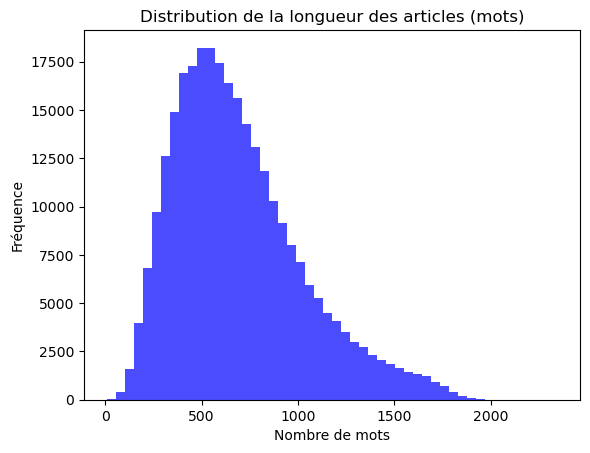

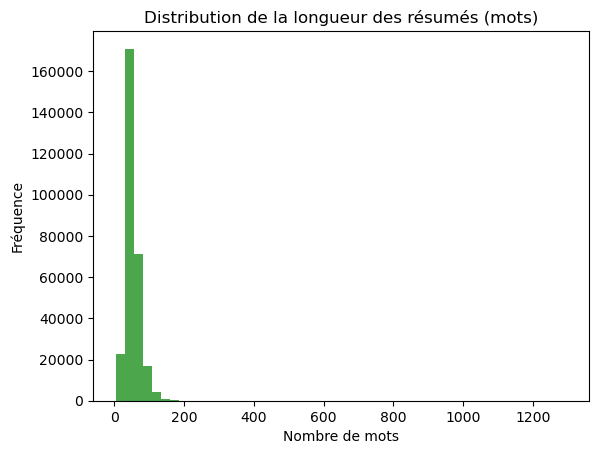

In [2]:
import matplotlib.pyplot as plt

train = dataset["train"]

article_lens = [len(a.split()) for a in train["article"]]
summary_lens = [len(s.split()) for s in train["highlights"]]

plt.hist(article_lens, bins=50, color="blue", alpha=0.7)
plt.title("Distribution de la longueur des articles (mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

plt.hist(summary_lens, bins=50, color="green", alpha=0.7)
plt.title("Distribution de la longueur des résumés (mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


## Longueur moyenne

In [3]:
import numpy as np

print("Article - moyenne:", np.mean(article_lens), "max:", np.max(article_lens))
print("Résumé - moyenne:", np.mean(summary_lens), "max:", np.max(summary_lens))


Article - moyenne: 691.8703263175126 max: 2347
Résumé - moyenne: 51.574101486174435 max: 1296


## Exemple concret

In [4]:
for i in range(3):
    print("Article:", train[i]["article"][:500], "...\n")
    print("Résumé:", train[i]["highlights"], "\n")
    print("="*80)


Article: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s ...

Résumé: Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund . 

Article: Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An in

## Vérifier le vocabulaire

In [5]:
from collections import Counter

words = " ".join(train[:2000]["article"]).split()
counter = Counter(words)
print(counter.most_common(20))


[('the', 62953), ('to', 32504), ('of', 29691), ('and', 27900), ('a', 27479), ('in', 24584), ('that', 11861), ('for', 10390), ('was', 9815), ('is', 9621), ('on', 8758), ('The', 8128), ('with', 7371), ('said', 7254), ('he', 6932), ('--', 6184), ('as', 5728), ('his', 5613), ('have', 5550), ('at', 5376)]


## Ratio article/résumé

In [6]:
ratios = [len(a.split())/len(s.split()) for a, s in zip(train["article"], train["highlights"])]
print("Ratio moyen (article/summary):", np.mean(ratios))


Ratio moyen (article/summary): 14.80257966981198


## Détection des anomalies

In [7]:
short_articles = sum(1 for l in article_lens if l < 20)
long_summaries = sum(1 for l in summary_lens if l > 200)
empty_summaries = sum(1 for s in train["highlights"] if len(s.strip()) == 0)

print("Articles courts:", short_articles)
print("Résumés très longs:", long_summaries)
print("Résumés vides:", empty_summaries)


Articles courts: 3
Résumés très longs: 174
Résumés vides: 0


# Préparation des données

In [8]:
from transformers import AutoTokenizer

# Choisir le tokenizer du modèle (ex. BART-base)
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

#  Définir les longueurs maximales (basées sur ton EDA)
max_input_length = 1024   # longueur max d’un article
max_target_length = 128   # longueur max d’un résumé

# Fonction de prétraitement pour tokeniser les textes
def preprocess_function(batch):
    # Tokenisation des articles
    inputs = tokenizer(
        batch["article"],
        max_length=max_input_length,
        truncation=True
    )

    # Tokenisation des résumés
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["highlights"],
            max_length=max_target_length,
            truncation=True
        )

    inputs["labels"] = labels["input_ids"]
    return inputs

# Application de la fonction sur les trois splits
tokenized_train = dataset["train"].map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
tokenized_val = dataset["validation"].map(preprocess_function, batched=True, remove_columns=dataset["validation"].column_names)
tokenized_test = dataset["test"].map(preprocess_function, batched=True, remove_columns=dataset["test"].column_names)

print(" Données tokenisées prêtes !")

# Vérification du résultat
print(tokenized_train)
print("Exemple de ligne tokenisée :")
print(tokenized_train[0])

C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map:   0%|                                                                            | 0/11490 [00:00<?, ? examples/s]C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\transformers\tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|███████████████████████████████████████████████████████████████| 11490/11490 [00:27<00:00, 415.66 examples/s]

 Données tokenisées prêtes !
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 287113
})
Exemple de ligne tokenisée :
{'input_ids': [0, 574, 4524, 6, 1156, 36, 1251, 43, 480, 3268, 10997, 999, 3028, 7312, 20152, 3077, 899, 7, 10, 431, 984, 844, 153, 1358, 4006, 4, 134, 153, 43, 13016, 25, 37, 4072, 504, 15, 302, 6, 53, 37, 9838, 5, 418, 351, 75, 2471, 10, 8921, 15, 123, 4, 3028, 7312, 20152, 25, 3268, 10997, 11, 22, 29345, 10997, 8, 5, 9729, 9, 5, 5524, 113, 598, 5, 10208, 9, 20445, 6730, 1952, 198, 5, 232, 6, 5, 664, 2701, 161, 37, 34, 117, 708, 7, 856, 3961, 1334, 39, 1055, 409, 15, 1769, 1677, 6, 4076, 8, 6794, 1799, 4, 22, 100, 218, 75, 563, 7, 28, 65, 9, 167, 82, 54, 6, 25, 1010, 25, 51, 1004, 504, 6, 6017, 907, 1235, 10, 2232, 1612, 512, 2783, 50, 402, 1122, 60, 37, 174, 41, 2059, 33242, 656, 42, 353, 4, 22, 100, 218, 75, 206, 38, 581, 28, 1605, 31879, 4, 22, 133, 383, 38, 101, 2159, 32, 383, 14, 701, 59, 158, 2697, 480, 2799, 8, 32570, 8, 37206, 72

# Entraînement du modèle (BART)

In [10]:
from transformers import (
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)

# Charger un modèle pré-entraîné plus léger pour tester (optionnel)
#    Tu peux remettre "facebook/bart-base" plus tard pour un vrai entraînement.
model_name = "facebook/bart-base"
# model_name = "facebook/bart-base"   # (décommente cette ligne pour la version complète)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Créer le data collator (gère le padding dynamique)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Réduire le dataset pour un entraînement plus rapide
small_train = tokenized_train.select(range(2000))   # 2000 exemples
small_val = tokenized_val.select(range(500))        # 500 exemples

# Paramètres d’entraînement optimisés pour la vitesse
training_args = Seq2SeqTrainingArguments(
    output_dir="results/bart-cnn-fast",
    evaluation_strategy="steps",
    eval_steps=200,              # évalue toutes les 200 étapes
    save_steps=200,              # sauvegarde toutes les 200 étapes
    learning_rate=5e-5,          # un peu plus élevé pour apprentissage rapide
    per_device_train_batch_size=1,  # pour CPU ou faible VRAM
    per_device_eval_batch_size=1,
    num_train_epochs=0.1,        # ≈ 1/10e d'époque (test rapide)
    max_steps=500,               # arrête après 500 batchs
    predict_with_generate=True,
    logging_steps=50,
    fp16=False,                  # à True si tu as un GPU compatible
    report_to="none"             # désactive Weights & Biases
)

# Configurer le Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Lancer l'entraînement rapide
trainer.train()

# Sauvegarder le modèle
trainer.save_model(r"C:\Users\lenovo\final_model")

print(" Entraînement rapide terminé et modèle sauvegardé.")


W1008 13:21:27.411000 5700 anaconda3\envs\ml\Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss
200,2.673100,2.425334
400,2.475600,2.363817


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters

 Entraînement rapide terminé et modèle sauvegardé.


## Entraînement du modèle (T5-small)

In [12]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from datasets import load_dataset

# Charger le dataset CNN/DailyMail
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Charger le tokenizer et le modèle T5
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Définir la fonction de prétraitement adaptée à T5
max_input_length = 1024
max_target_length = 128

def preprocess_function_t5(batch):
    # T5 attend une consigne explicite, ex: "summarize: <texte>"
    inputs = ["summarize: " + doc for doc in batch["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    
    # Tokenisation des résumés (targets)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["highlights"], max_length=max_target_length, truncation=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenisation du dataset (sous-ensemble pour test rapide)
tokenized_train_t5 = dataset["train"].select(range(2000)).map(
    preprocess_function_t5,
    batched=True,
    remove_columns=dataset["train"].column_names
)

tokenized_val_t5 = dataset["validation"].select(range(500)).map(
    preprocess_function_t5,
    batched=True,
    remove_columns=dataset["validation"].column_names
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Paramètres d’entraînement rapides (CPU-friendly)
training_args = Seq2SeqTrainingArguments(
    output_dir="results/t5-small-cnn",
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=0.1,
    max_steps=500,
    predict_with_generate=True,
    logging_steps=50,
    fp16=False,
    report_to="none"
)

# Configurer le Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_t5,
    eval_dataset=tokenized_val_t5,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Lancer l'entraînement
trainer.train()

# Sauvegarder le modèle
trainer.save_model(r"C:\Users\lenovo\final_model_t5")

print(" Entraînement T5-small terminé et modèle sauvegardé.")


Map:   0%|                                                                             | 0/2000 [00:00<?, ? examples/s]C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\transformers\tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|███████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 348.20 examples/s]
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
200,2.135600,2.066094
400,2.084800,2.053424


C:\Users\lenovo\anaconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


 Entraînement T5-small terminé et modèle sauvegardé.


# Evaluation des deux modéles

## La fonction d’évaluation commune

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric
import numpy as np
from tqdm import tqdm
from evaluate import load

dataset = load_dataset("cnn_dailymail", "3.0.0")
test_data = dataset["validation"].select(range(100))  # 100 exemples pour évaluation rapide


# Charger les métriques
rouge_metric = load("rouge")
bleu_metric = load("bleu")

def evaluate_model(model_path, model_name, num_samples=50):
    print(f"\n Évaluation du modèle : {model_name}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    bleu_scores = []
    
    for i in tqdm(range(num_samples)):
        article = test_data[i]["article"]
        reference = test_data[i]["highlights"]

        # Tokenisation
        inputs = tokenizer(article, return_tensors="pt", truncation=True, max_length=512)
        summary_ids = model.generate(**inputs, max_length=128, num_beams=4)
        pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        # Calcul ROUGE (texte brut)
        rouge_result = rouge_metric.compute(predictions=[pred], references=[reference])
        for key in rouge_scores.keys():
            rouge_scores[key].append(rouge_result[key] * 100)

        # Calcul BLEU (texte brut, sans split)
        bleu_result = bleu_metric.compute(predictions=[pred], references=[[reference]])
        bleu_scores.append(bleu_result["bleu"] * 100)

    # Moyennes finales
    avg_scores = {
        "ROUGE-1": np.mean(rouge_scores["rouge1"]),
        "ROUGE-2": np.mean(rouge_scores["rouge2"]),
        "ROUGE-L": np.mean(rouge_scores["rougeL"]),
        "BLEU": np.mean(bleu_scores)
    }

    print(f"\n Résultats {model_name} : {avg_scores}")
    return avg_scores


## Évaluer les deux modèles

In [8]:
results = {}

results["BART"] = evaluate_model(r"C:\Users\lenovo\final_model", "BART-base", num_samples=50)
results["T5-small"] = evaluate_model(r"C:\Users\lenovo\final_model_t5", "T5-small", num_samples=50)

print("\n Résumé comparatif final :")
for model_name, score in results.items():
    print(f"{model_name}: {score}")



 Évaluation du modèle : BART-base


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]



 Résultats BART-base : {'ROUGE-1': 30.035885047604392, 'ROUGE-2': 10.929268946874158, 'ROUGE-L': 20.36491711276086, 'BLEU': 5.175831757038713}

 Évaluation du modèle : T5-small


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:23<00:00,  4.07s/it]


 Résultats T5-small : {'ROUGE-1': 26.56062392267422, 'ROUGE-2': 11.298477070492503, 'ROUGE-L': 19.39997541009296, 'BLEU': 6.4583888678701395}

 Résumé comparatif final :
BART: {'ROUGE-1': 30.035885047604392, 'ROUGE-2': 10.929268946874158, 'ROUGE-L': 20.36491711276086, 'BLEU': 5.175831757038713}
T5-small: {'ROUGE-1': 26.56062392267422, 'ROUGE-2': 11.298477070492503, 'ROUGE-L': 19.39997541009296, 'BLEU': 6.4583888678701395}


## Tableau de comparaison

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


results = {
     "BART":  {'ROUGE-1': 30.035885047604392, 'ROUGE-2': 10.929268946874158, 'ROUGE-L': 20.36491711276086, 'BLEU': 5.175831757038713},
    "T5-small":  {'ROUGE-1': 26.56062392267422, 'ROUGE-2': 11.298477070492503, 'ROUGE-L': 19.39997541009296, 'BLEU': 6.4583888678701395}
 }


# ---  Création du tableau de comparaison ---
df = pd.DataFrame(results).T  # transpose pour avoir les modèles en lignes
df = df.round(2)
print(" Tableau comparatif des performances :\n")
display(df)


 Tableau comparatif des performances :



,ROUGE-1,ROUGE-2,ROUGE-L,BLEU
BART,30.04,10.93,20.36,5.18
T5-small,26.56,11.30,19.40,6.46


## Afficher un graphique comparatif

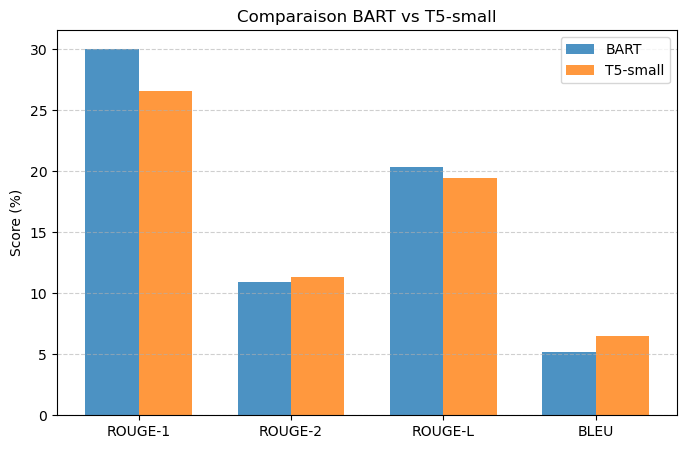

In [15]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"]
bart_scores = [results["BART"][m] for m in metrics]
t5_scores = [results["T5-small"][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, bart_scores, width, label="BART", alpha=0.8)
plt.bar(x + width/2, t5_scores, width, label="T5-small", alpha=0.8)

plt.xticks(x, metrics)
plt.ylabel("Score (%)")
plt.title("Comparaison BART vs T5-small")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## Comparaison qualitative

In [16]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import textwrap

# Charger le dataset CNN/DailyMail
dataset = load_dataset("cnn_dailymail", "3.0.0")
sample = dataset["test"][0]  # tu peux changer l’index (ex. 10, 25, 50…)

article = sample["article"]
reference = sample["highlights"]

# Charger les deux modèles
bart_path = r"C:\Users\lenovo\final_model"
t5_path = r"C:\Users\lenovo\final_model_t5"

bart_tokenizer = AutoTokenizer.from_pretrained(bart_path)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_path)

t5_tokenizer = AutoTokenizer.from_pretrained(t5_path)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_path)

# --- Fonction pour générer un résumé ---
def generate_summary(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model.generate(**inputs, max_length=128, num_beams=4)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Génération des résumés
bart_summary = generate_summary(bart_model, bart_tokenizer, article)
t5_summary = generate_summary(t5_model, t5_tokenizer, article)

# --- Affichage formaté ---
wrapper = textwrap.TextWrapper(width=120)

print("\n" + "="*80)
print(" ARTICLE :\n")
print(wrapper.fill(article[:1500]) + "...\n")  # tronque pour lisibilité

print("="*80)
print(" RÉSUMÉ RÉEL :\n")
print(wrapper.fill(reference))

print("="*80)
print(" RÉSUMÉ GÉNÉRÉ PAR BART :\n")
print(wrapper.fill(bart_summary))

print("="*80)
print(" RÉSUMÉ GÉNÉRÉ PAR T5-small :\n")
print(wrapper.fill(t5_summary))
print("="*80)



 ARTICLE :

(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a
step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked
with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding
Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied
Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary
examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against
Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States,
neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister
Riad al-Malki, speaking at Wednesday's

## Meilleur modèle par métrique

In [17]:
best_by_metric = df.idxmax()
print("\n Meilleur modèle par métrique :\n")
display(best_by_metric)



 Meilleur modèle par métrique :



ROUGE-1        BART
ROUGE-2    T5-small
ROUGE-L        BART
BLEU       T5-small
dtype: object